<!-- ABSTRACT -->

The goal of this script is to check how well the model performs on the test set. For this, we will look at the overall test set, as well as some specific cases, that we will visualize.

In [1]:
import os
import sys
import json
import joblib
import geopandas as gpd
import torch
import help_functions as hf
import pandas as pd

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn  # or whatever you need to import
import help_functions as hf

In [2]:
# Parameters to adapt

run_path = '../../data/runs_01_2025/'
unique_model_description = "1pct_10k/"
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
base_case_path = '../../data/links_and_stats/pop_1pct_basecase_average_output_links.geojson'
result_path = '../../data/results/results_01_2025/'

# Parameters
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512,256" 
dropout = 0.3
use_dropout = False
predict_mode_stats = False
in_channels = 5
out_channels = 1
        
run_path = run_path + unique_model_description
data_created_during_training = run_path + 'data_created_during_training/'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")

# Load scalers
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

# run_path = '/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/data/runs_21_10_2024/'
# point_net_conv_layer_structure_local_mlp = "256"
# point_net_conv_layer_structure_global_mlp = "512"
# gat_conv_layer_structure = "128,256,512,256" 
# dropout = 0.3
# use_dropout = False 
# predict_mode_stats = False
# in_channels = 13
# out_channels = 1 
# loss_fct = torch.nn.MSELoss()

# # The rest we can usually leave as is
# districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
# pnc_l_string = point_net_conv_layer_structure_local_mlp.replace(',', '_')
# pnc_g_string = point_net_conv_layer_structure_global_mlp.replace(',', '_') 
# gat_string = gat_conv_layer_structure.replace(',', '_')

# unique_model_description = f"pnc_local_[{pnc_l_string}]_" + \
# f"pnc_global_[{pnc_g_string}]_" + \
# f"gat_conv_[{gat_string}]_" + \
# f"use_dropout_{use_dropout}_" + \
# f"dropout_{dropout}_" + \
# f"predict_mode_stats_{predict_mode_stats}" + "/"
        
# run_path = run_path + unique_model_description
# base_case_path = '../../data/test_data/pop_1pm_basecase_mean_links_NEW.geojson'
# links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")
# model_path = run_path +  'trained_model/model.pth'
# data_created_during_training = run_path + 'data_created_during_training/'
# scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
# scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

In [3]:
# # Load the test dataset created during training
# test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# # Load the DataLoader parameters
# with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
#     test_set_dl_loader_params = json.load(f)
    
# # Remove or correct collate_fn if it is incorrectly specified
# if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
#     del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
# test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [4]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model_path = run_path + 'trained_model/model.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_fct = torch.nn.MSELoss().to(dtype=torch.float32).to(device)
loss_fct_mae = torch.nn.L1Loss().to(dtype=torch.float32).to(device)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
  ))
  (read_out_node_predictions): Linear(in_features=64, out_features=1, bias=True)
  (gat_graph_layers): Sequential(
    (0) - TransformerConv(128, 64, heads=4): x, edge_index -> x
    (1) - ReLU(inplace=True): x -> x
    (2) - TransformerConv(256, 128, heads=4): x, edge_index -> x
    (3) - ReLU(inplace=True): x -> x
    (4) - TransformerConv(512, 64, heads=4): x,

In [5]:
# test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

# print(f"Test Loss: {test_loss}")
# print(f"R-squared: {r_squared}")
# print(f"Baseline Loss: {baseline_loss}")

# Next, we will look at single elements of the test set and visualize the performance of the model.


Test 5
Test Loss: 4.134496416364398
R-squared: 0.804646372795105
Baseline Loss: 148.14915466308594


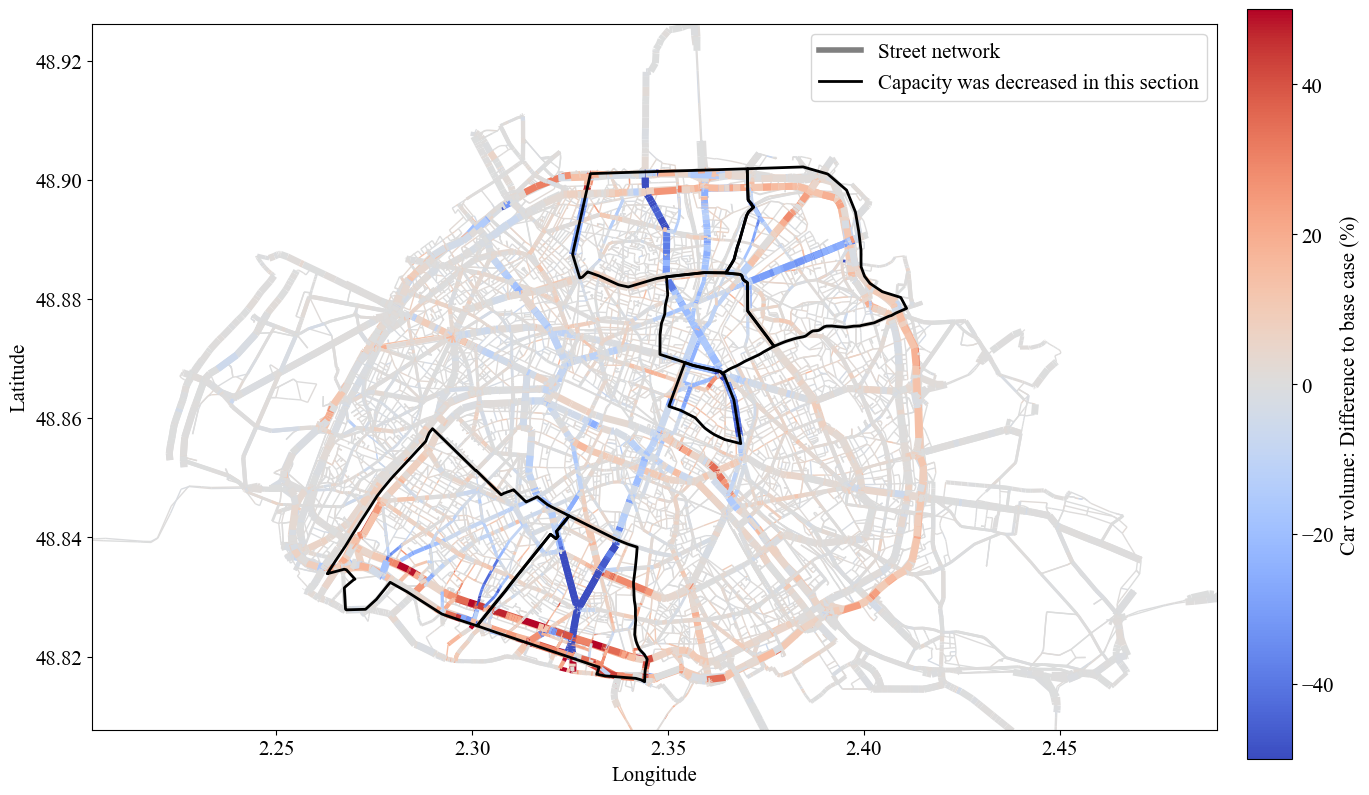

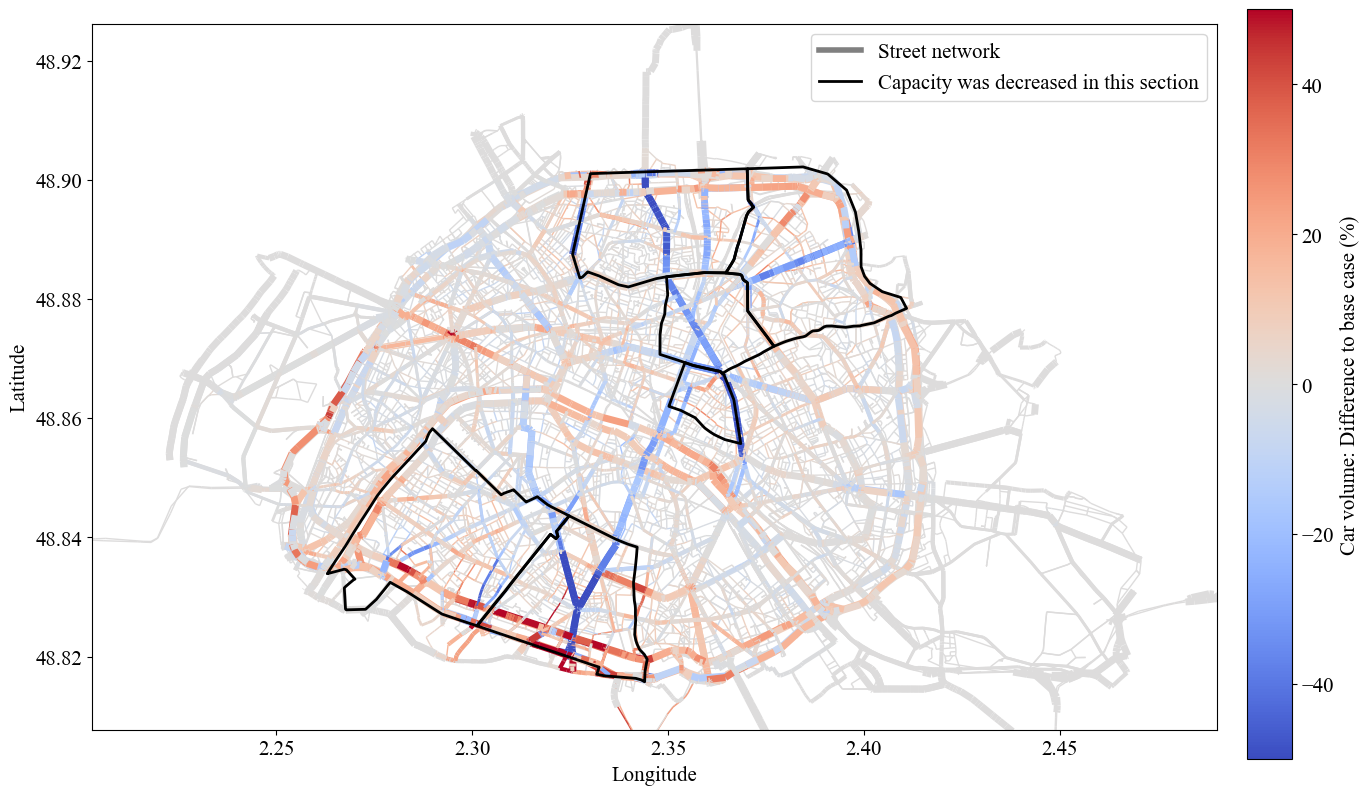

In [6]:
fixed_norm_max = 50

for i in range(10):
    if i != 5:
        continue
    # if i != 14 and i != 21 and i != 33 and i != 38 and i != 39 and i != 45 and i != 58:
    #     continue
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    
    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    print(f"Test {i}")
    print(f"Test Loss: {test_loss_my_test_data}")
    print(f"R-squared: {r_squared_my_test_data}")
    print(f"Baseline Loss: {baseline_loss_my_test_data}")

    inversed_x = scaler_x.inverse_transform(my_test_x)

    gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
    gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                            save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)
    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
                            number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)

In [7]:
# PRINT ABSOLUTE CAR VOLUME

# non_zero_vol_base_case = gdf_with_og_values[gdf_with_og_values['vol_base_case'] != 0]
# non_zero_vol_base_case

# gdf_with_og_values['vol_car_predicted'] = (gdf_with_og_values['vol_base_case'] + gdf_with_og_values['vol_car_change_predicted'])*10
# gdf_with_og_values.head()

# non_zero_vol_base_case = gdf_with_og_values[gdf_with_og_values['vol_base_case'] != 0]
# print(non_zero_vol_base_case)

# hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_predicted", 
#                             save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
#                             fixed_norm_max = None,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, is_absolute=True)

In [8]:
indices_roads_with_highway_primary_sec_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([1,2,3])].index
indices_roads_with_highway_primary_ = gdf_with_og_values[gdf_with_og_values['highway'].isin([1])].index
indices_roads_with_highway_sec = gdf_with_og_values[gdf_with_og_values['highway'].isin([2])].index
indices_roads_with_highway_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([3])].index
indices_roads_with_highway_not_primary_sec_tertiary = gdf_with_og_values[~gdf_with_og_values['highway'].isin([1, 2, 3])].index

tolerance = 1e-3
indices_roads_with_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] < -1e-3].index
indices_roads_with_no_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3].index

indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
].index
indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
].index
indices_roads_with_highway_trunk = gdf_with_og_values[gdf_with_og_values['highway'].isin([0])].index
indices_roads_with_highway_residential_street = gdf_with_og_values[gdf_with_og_values['highway'].isin([4])].index
indices_roads_with_highway_living_street = gdf_with_og_values[gdf_with_og_values['highway'].isin([5])].index


In [9]:
from scipy import stats

def compute_correlations_scipy(predictions, targets):
    """
    Compute correlations using scipy (for verification)
    """
    pred_np = predictions.detach().cpu().numpy()
    target_np = targets.detach().cpu().numpy()
    
    spearman_corr, _ = stats.spearmanr(pred_np, target_np)
    pearson_corr, _ = stats.pearsonr(pred_np, target_np)
    
    return spearman_corr, pearson_corr

def validate_model_with_interpretable_error(indices, gdf, loss_fct, tolerance):
    loss_fct_l1 = torch.nn.L1Loss()
    base_car_vol = gdf.loc[indices, 'vol_base_case']
    actual_vals = gdf.loc[indices, 'vol_car_change_actual']
    predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
    
    actual_vals = actual_vals.to_numpy()
    predicted_vals = predicted_vals.to_numpy()
    actual_mean = torch.mean(torch.tensor(actual_vals))
    
    baseline_vals = torch.full_like(torch.tensor(actual_vals), actual_mean)
    r_squared = hf.compute_r2_torch(preds=torch.tensor(predicted_vals), targets=torch.tensor(actual_vals))
    r_squared = round(r_squared.item(), 2)
    
    baseline_vals_np = baseline_vals.numpy()
    base_car_vol_np = base_car_vol.to_numpy()
    
    baseline_car_vol = base_car_vol_np + baseline_vals_np
    actual_car_vol = base_car_vol + actual_vals
    predicted_car_vol = base_car_vol + predicted_vals
    
    mse_loss = loss_fct(torch.tensor(actual_vals), torch.tensor(predicted_vals))
    l1_loss = loss_fct_l1(torch.tensor(actual_vals), torch.tensor(predicted_vals))

    baseline_mse = loss_fct(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))
    baseline_l1 = loss_fct_l1(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))
    
    error_normalized_by_mean_squared = mse_loss /   torch.mean(torch.tensor(actual_vals)).pow(2)
    baseline_normalized_by_mean_squared = baseline_mse / torch.mean(torch.tensor(actual_vals)).pow(2)
    
    variance_actual_car_vol = torch.var(torch.tensor(actual_vals))
    error_normalized_by_variance = mse_loss / variance_actual_car_vol
    baseline_normalized_by_variance = baseline_mse / variance_actual_car_vol
    
    spearman_corr, pearson_corr = compute_correlations_scipy(torch.tensor(actual_vals), torch.tensor(predicted_vals))
    
    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    mean_relative_errors, mean_filtered_relative_errors = compute_relative_error_and_relative_filtered_error(actual_car_vol, predicted_car_vol, tolerance)
    mean_relative_errors_baseline, mean_filtered_relative_errors_baseline = compute_relative_error_and_relative_filtered_error(actual_car_vol, baseline_car_vol, tolerance)
    
    print(f"R-squared: {r_squared}")
    print(f"MSE Loss: {mse_loss}")
    print(f"Baseline Loss: {baseline_mse}")
    # print(f"L1 Loss: {l1_loss}")
    # print(f"Baseline L1 loss: {baseline_l1}")
    # print(f"Error normalized by mean squared: {error_normalized_by_mean_squared:.4f}")
    # print(f"Baseline normalized by mean squared: {baseline_normalized_by_mean_squared:.4f}")
    print(f"Error normalized by variance: {error_normalized_by_variance:.4f}")
    print(f"Baseline normalized by variance: {baseline_normalized_by_variance:.4f}")
    print(f"Mean Relative Error: {mean_relative_errors:.4f}")
    print(f"Mean Filtered Relative Error: {mean_filtered_relative_errors:.4f}")
    print(f"Baseline Mean Relative Error: {mean_relative_errors_baseline:.4f}")
    print(f"Baseline Mean Filtered Relative Error: {mean_filtered_relative_errors_baseline:.4f}")
    print(" ")
    
    return

def compute_relative_error_and_relative_filtered_error(actual_car_vol, car_vol_to_compare, tolerance):
    actual_car_vol[actual_car_vol == 0] = 1e-10
    absolute_errors = torch.abs(torch.tensor(car_vol_to_compare) - torch.tensor(actual_car_vol))
    relative_errors = absolute_errors / torch.tensor(actual_car_vol)
    filtered_relative_errors = relative_errors[(relative_errors <= tolerance) & (relative_errors >= -tolerance)]
    mean_relative_errors = torch.mean(relative_errors)
    mean_filtered_relative_errors = torch.mean(filtered_relative_errors)
    return mean_relative_errors,mean_filtered_relative_errors

loss_fct = torch.nn.MSELoss()

print("All Roads")
validate_model_with_interpretable_error(gdf_with_og_values.index, gdf_with_og_values, loss_fct, 10000)
# print("Primary, Secondary, Tertiary Roads")
# validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_highway_primary_sec_tertiary), step=1), gdf_with_og_values, loss_fct, 10000)

print("Trunk Roads")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_highway_trunk), step=1), gdf_with_og_values, loss_fct, 10000)

print("Residential Streets")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_highway_residential_street), step=1), gdf_with_og_values, loss_fct, 10000)

print("Living Streets")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_highway_living_street), step=1), gdf_with_og_values, loss_fct, 10000)

print("Primary Roads")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_highway_primary_), step=1), gdf_with_og_values, loss_fct, 10000)
print("Secondary Roads")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_highway_sec), step=1), gdf_with_og_values, loss_fct, 10000)
print("Tertiary Roads")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_highway_tertiary), step=1), gdf_with_og_values, loss_fct, 10000)

print("Non-Primary, Non-Secondary, Non-Tertiary Roads")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_highway_not_primary_sec_tertiary), step=1), gdf_with_og_values, loss_fct, 10000)
print("Capacity Reduction Roads")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_cap_reduction), step=1), gdf_with_og_values, loss_fct, 10000)
print("No Capacity Reduction Roads")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_no_cap_reduction), step=1), gdf_with_og_values, loss_fct, 10000)
print("Primary, Secondary, Tertiary Roads with Capacity Reduction")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction), step=1), gdf_with_og_values, loss_fct, 10000)
print("Primary, Secondary, Tertiary Roads with No Capacity Reduction")
validate_model_with_interpretable_error(pd.RangeIndex(start=0, stop=len(indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction), step=1), gdf_with_og_values, loss_fct, 10000)


All Roads
Spearman Correlation: 0.4920
Pearson Correlation: 0.8979
R-squared: 0.8
MSE Loss: 28.941471099853516
Baseline Loss: 148.14915466308594
Error normalized by variance: 0.1953
Baseline normalized by variance: 1.0000
Mean Relative Error: 19052377436.9200
Mean Filtered Relative Error: 0.2056
Baseline Mean Relative Error: 16822322528.1678
Baseline Mean Filtered Relative Error: 0.2093
 
Trunk Roads
Spearman Correlation: 0.4478
Pearson Correlation: 0.8731
R-squared: 0.76
MSE Loss: 26.586753845214844
Baseline Loss: 110.70158386230469
Error normalized by variance: 0.2399
Baseline normalized by variance: 0.9989
Mean Relative Error: 610693247834.5427
Mean Filtered Relative Error: 0.2116
Baseline Mean Relative Error: 483261724264.9254
Baseline Mean Filtered Relative Error: 0.2009
 
Residential Streets
Spearman Correlation: 0.4995
Pearson Correlation: 0.8957
R-squared: 0.8
MSE Loss: 29.21227264404297
Baseline Loss: 146.4571990966797
Error normalized by variance: 0.1994
Baseline normalized b

In [10]:
# Convert the GeoDataFrame to the appropriate coordinate reference system (CRS) for length calculation
gdf_in_meters = gdf_with_og_values.to_crs("EPSG:32633")
gdf_in_meters['length'] = gdf_in_meters.length
total_length = gdf_in_meters['length'].sum() / 1000
print(f"Total length of the street network: {total_length:.2f} km")
gdf_with_reductions = gdf_in_meters.loc[indices_roads_with_cap_reduction]
total_length_with_reductions = gdf_with_reductions['length'].sum() / 1000
print(f"Total length of the street network with capacity reductions: {total_length_with_reductions:.2f} km")

Total length of the street network: 2872.02 km
Total length of the street network with capacity reductions: 240.87 km


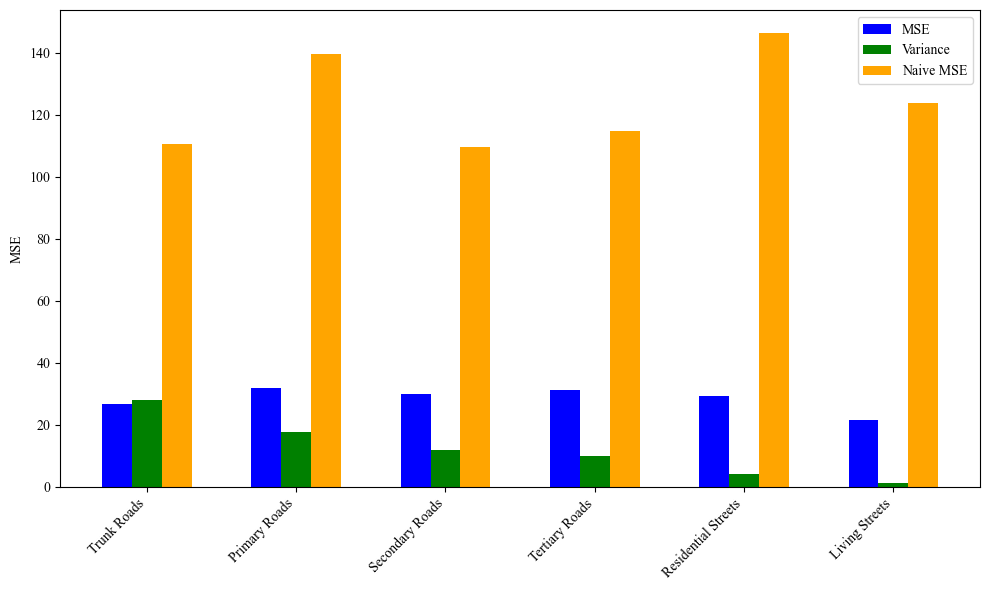

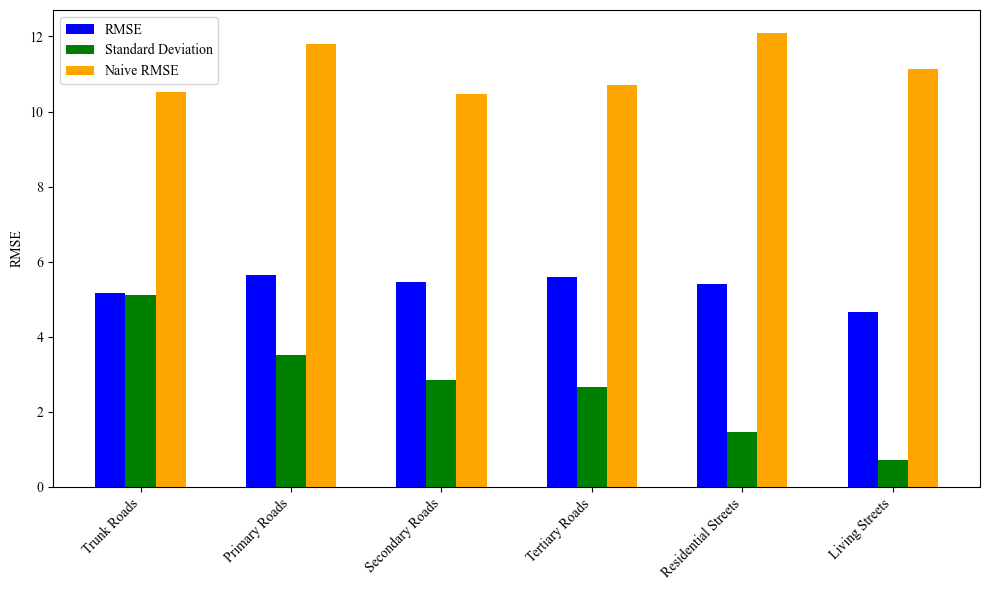

In [11]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Data for the plots
# road_types = [
#     "Trunk Roads",
#     "Primary Roads",
#     "Secondary Roads",
#     "Tertiary Roads",
#     "Residential Streets",
#     "Living Streets",
# ]

# # MSE and RMSE Data
# mse = [26.59, 31.80, 29.82, 31.19, 29.21, 21.59]
# variance = [28.14, 17.55, 11.92, 9.82, 3.99, 1.09]
# naive_mse = [110.70, 139.50, 109.63, 114.73, 146.46, 123.91]

# rmse = [5.16, 5.64, 5.46, 5.58, 5.40, 4.65]
# std_dev = [5.12, 3.50, 2.85, 2.65, 1.46, 0.72]
# naive_rmse = [10.52, 11.81, 10.47, 10.71, 12.10, 11.13]

# x = np.arange(len(road_types))  # x locations for the bars

# # Set font to Times New Roman
# plt.rcParams["font.family"] = "Times New Roman"

# # Plot for MSE
# plt.figure(figsize=(10, 6))
# plt.bar(x - 0.2, mse, width=0.2, label="MSE", color="blue")
# plt.bar(x, variance, width=0.2, label="Variance", color="green")
# plt.bar(x + 0.2, naive_mse, width=0.2, label="Naive MSE", color="orange")
# plt.xticks(x, road_types, rotation=45, ha="right")
# plt.ylabel("MSE")
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Plot for RMSE
# plt.figure(figsize=(10, 6))
# plt.bar(x - 0.2, rmse, width=0.2, label="RMSE", color="blue")
# plt.bar(x, std_dev, width=0.2, label="Standard Deviation", color="green")
# plt.bar(x + 0.2, naive_rmse, width=0.2, label="Naive RMSE", color="orange")
# plt.xticks(x, road_types, rotation=45, ha="right")
# plt.ylabel("RMSE")
# plt.legend()
# plt.tight_layout()
# plt.show()


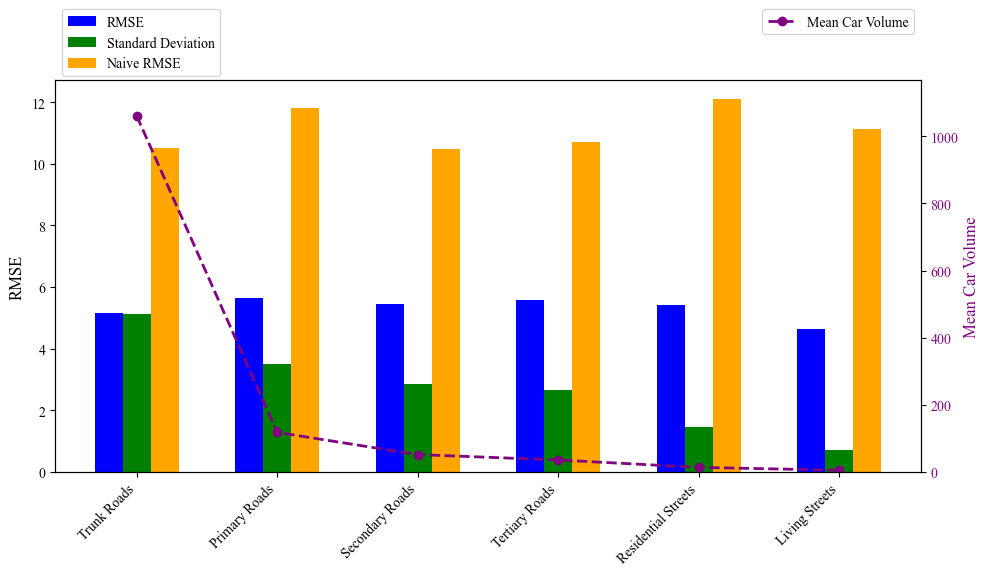

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
road_types = [
    "Trunk Roads",
    "Primary Roads",
    "Secondary Roads",
    "Tertiary Roads",
    "Residential Streets",
    "Living Streets",
]

rmse = [5.16, 5.64, 5.46, 5.58, 5.40, 4.65]
std_dev = [5.12, 3.50, 2.85, 2.65, 1.46, 0.72]
naive_rmse = [10.52, 11.81, 10.47, 10.71, 12.10, 11.13]
mean_car_volume = [1060.73, 117.58, 51.46, 35.37, 13.27, 4.81]

x = np.arange(len(road_types))  # x locations for the bars

# Set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Plot for RMSE with Mean Car Volume overlay
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for RMSE, Std. Dev., and Naive RMSE
bar_width = 0.2
ax1.bar(x - bar_width, rmse, width=bar_width, label="RMSE", color="blue")
ax1.bar(x, std_dev, width=bar_width, label="Standard Deviation", color="green")
ax1.bar(x + bar_width, naive_rmse, width=bar_width, label="Naive RMSE", color="orange")
ax1.set_ylabel("RMSE", fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(road_types, rotation=45, ha="right")
ax1.legend(loc="upper left", fontsize=10, bbox_to_anchor=(0, 1.2))  # Adjusted position to make the legend box higher

# Second y-axis for Mean Car Volume
ax2 = ax1.twinx()
ax2.plot(x, mean_car_volume, label="Mean Car Volume", color="purple", marker="o", linestyle="dashed", linewidth=2)
ax2.set_ylabel("Mean Car Volume", fontsize=12, color="purple")
ax2.tick_params(axis="y", labelcolor="purple")
ax2.set_ylim(0, max(mean_car_volume) * 1.1)  # Ensure the secondary y-axis starts at 0
ax2.legend(loc="upper right", fontsize=10)
ax2.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1, 1.2))  # Adjusted position to make the legend box higher


plt.savefig("rmse_with_mean_car_volume.png", dpi=300, bbox_inches="tight")

# Tight layout and show plot
plt.tight_layout()
plt.show()
